In [1]:
from models.det_allhist_glm import Det_AllHist_GLM

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
Z_file = "spk_loc.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
Z = torch.from_numpy(Z)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 750
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 4800
epoch_no = 16
layer_no = 3

In [4]:
Z_train = Z[:T_train].float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Det_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

135


In [ ]:
t = torch.arange(T_no+1).to(device)
t_tau = t / 5
kern = t_tau * torch.exp(-t_tau)
kern = torch.flip(kern, [0])

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_Z = Z_train[batch_idx : batch_idx+batch_size].to(device)
    
    Z_pred, P_pred, out_filters = model(batch_E_neural, batch_I_neural)
    
    filt_batch_Z = F.conv1d(batch_Z.reshape(1,1,-1), kern.reshape(1,1,-1), padding=T_no//2).flatten()
    filt_pred_Z = F.conv1d(Z_pred[:,0].reshape(1,1,-1), kern.reshape(1,1,-1), padding=T_no//2).flatten()
    
        
    loss = torch.mean((filt_batch_Z - filt_pred_Z)**2)
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_Z_pred, test_P_pred, test_out_filters = model(test_E_neural, test_I_neural)
        
        filt_test_Z = F.conv1d(Z_test.reshape(1,1,-1), kern.reshape(1,1,-1), padding=T_no//2).flatten()
        filt_test_pred_Z = F.conv1d(test_Z_pred[:,0].reshape(1,1,-1), kern.reshape(1,1,-1), padding=T_no//2).flatten()
         
        test_loss = torch.mean((filt_test_Z - filt_test_pred_Z)**2).item()
        test_P = torch.mean(test_P_pred[:,0]).item()
        
        print(i, test_loss, test_P, torch.sum(test_Z_pred).item())


<ipython-input-6-4c6bbe171dc1>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 0.03409025818109512 0.4774966239929199 1081.0
199 0.030134038999676704 0.47763362526893616 1027.0
299 0.022107794880867004 0.47858333587646484 911.0
399 0.015884442254900932 0.4794026017189026 808.0
499 0.014354875311255455 0.47920671105384827 778.0
599 0.012934921309351921 0.4789765179157257 735.0
699 0.011565563268959522 0.4786304831504822 706.0
799 0.009861322119832039 0.47846272587776184 673.0
899 0.008995597250759602 0.47779616713523865 650.0
999 0.00813815277069807 0.47750765085220337 617.0
1099 0.007482496090233326 0.4769972860813141 594.0
1199 0.007191588170826435 0.4764930307865143 571.0
1299 0.006622707936912775 0.4758789837360382 550.0
1399 0.006069365888834 0.47547319531440735 526.0
1499 0.00574974250048399 0.4751490652561188 486.0
1599 0.005345962941646576 0.47481265664100647 468.0
1699 0.00512654660269618 0.47431984543800354 448.0
1799 0.004687964450567961 0.4739355742931366 425.0
1899 0.004495757631957531 0.47335919737815857 411.0
1999 0.004308965522795916 0.473136812

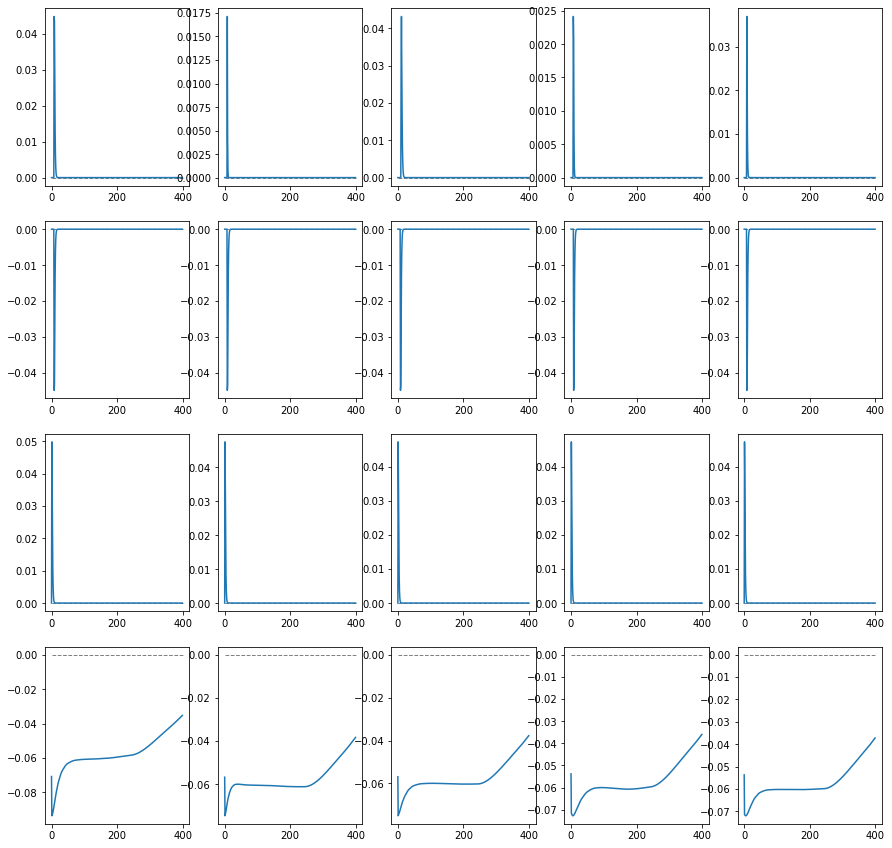

In [7]:
sub_no = 5
fig, axs = plt.subplots(nrows=4, ncols=sub_no, figsize=(15,15))
for row in range(4):
    for col in range(sub_no):
        axs[row,col].plot(test_out_filters[row*sub_no+col].cpu().detach().numpy()[:750])
        axs[row,col].hlines(y=0,xmin=0,xmax=400, color="gray",linewidth=1,linestyle="--")

tensor(0.0044, device='cuda:0', grad_fn=<MeanBackward0>)


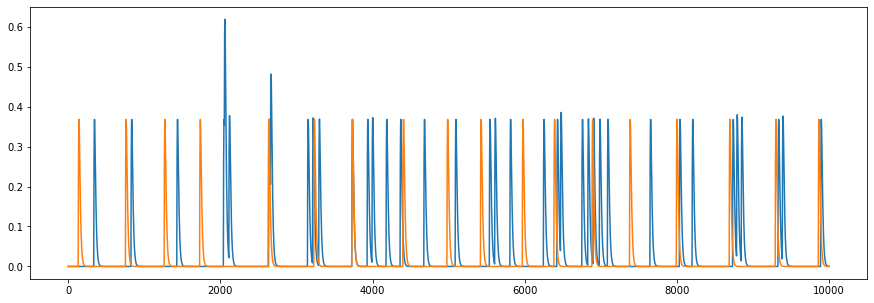

In [8]:
plt.figure(figsize=(15,5))
plt.plot(filt_test_Z.cpu().detach().numpy()[16000:26000])
plt.plot(filt_test_pred_Z.cpu().detach().numpy()[16000:26000])
print(torch.mean((filt_test_Z - filt_test_pred_Z)**2))

tensor(0.0044, device='cuda:0', grad_fn=<MeanBackward0>)


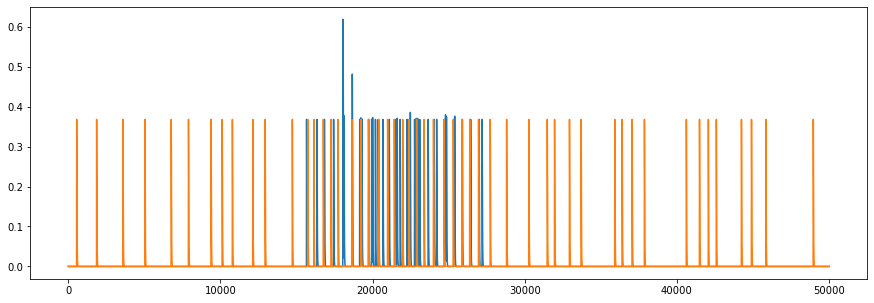

In [9]:
plt.figure(figsize=(15,5))
plt.plot(filt_test_Z.cpu().detach().numpy()[:])
plt.plot(filt_test_pred_Z.cpu().detach().numpy()[:])
print(torch.mean((filt_test_Z - filt_test_pred_Z)**2))

In [10]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Tau_syn tensor([[ 0.0000,  0.0000],
        [-0.7820,  0.0000],
        [ 0.0896,  0.0000],
        [-0.5225,  0.0000],
        [-0.3188,  0.0000]], device='cuda:0')
Delta_syn tensor([[2.0000, 2.0000],
        [1.9457, 2.0000],
        [2.2611, 2.0000],
        [1.9045, 2.0000],
        [1.9590, 2.0000]], device='cuda:0')
W_syn tensor([[-2.0000, -2.0000],
        [-2.7369, -2.0000],
        [-2.0879, -2.0000],
        [-2.4879, -2.0000],
        [-2.3034, -2.0000]], device='cuda:0')
Tau_spk tensor([ 0.0000, -0.0467, -0.0497, -0.0496, -0.0490], device='cuda:0')
Delta_spk tensor([0., 0., 0., 0., 0.], device='cuda:0')
W_spk tensor([-2.0000, -2.0480, -2.0510, -2.0502, -2.0498], device='cuda:0')
W_hist tensor([[-0.0476, -0.0473, -0.0470, -0.0468, -0.0464, -0.0453, -0.0433, -0.0403,
         -0.0366, -0.0333, -0.0313, -0.0305, -0.0303, -0.0303, -0.0295, -0.0274],
        [-0.0381, -0.0377, -0.0373, -0.0371, -0.0365, -0.0354, -0.0337, -0.0320,
         -0.0306, -0.0298, -0.0301, -0.0303, -0.0

tensor(0.0044, device='cuda:0', grad_fn=<MeanBackward0>)
-1.0568954944610596


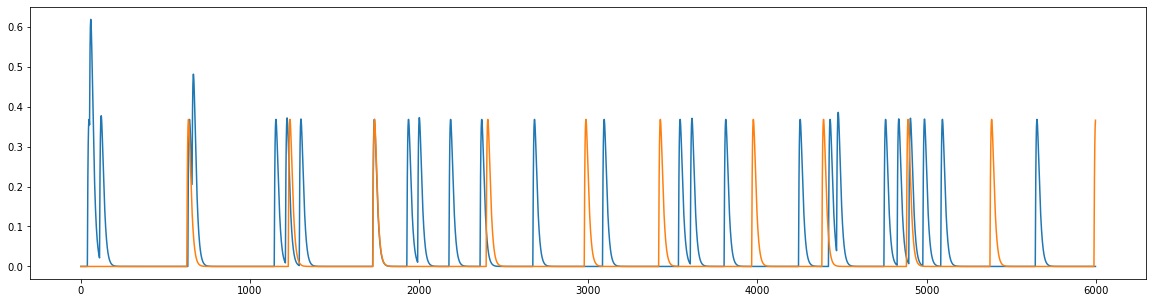

In [11]:
plt.figure(figsize=(20,5))
plt.plot(filt_test_Z.cpu().detach().numpy()[18000:24000])
plt.plot(filt_test_pred_Z.cpu().detach().numpy()[18000:24000])
print(torch.mean((filt_test_Z - filt_test_pred_Z)**2))
print(explained_variance_score(filt_test_Z.cpu().detach().numpy(), filt_test_pred_Z.cpu().detach().numpy()))